Save locations of train, test and gold data

In [1]:
from pandas import DataFrame, read_csv
import pandas as pd
import matplotlib.pyplot as plt
import nltk

Location = r'../twitter_data/train2017.tsv'
df = pd.read_csv(Location,delimiter = '\t',names=['id','id2','tag','text'])

Location_test = r'../twitter_data/test2017.tsv'
df_test = pd.read_csv(Location_test,delimiter = '\t',names=['id','id2','tag','text'])

Location_corrects = r'../twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt'
df_corrects = pd.read_csv(Location_corrects,delimiter = '\t',names=['id','tag'])

Initializing stemmer and lemmatizer. get_wordnet_pos defined

In [2]:
from bs4 import BeautifulSoup
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import StemmerI, RegexpStemmer, LancasterStemmer, ISRIStemmer, PorterStemmer, SnowballStemmer, RSLPStemmer
from string import punctuation
from nltk.stem import  WordNetLemmatizer
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

lemmatizer = WordNetLemmatizer()

stemmer = PorterStemmer()

clean_text function

In [3]:
import nltk

def clean_text(tweet):
    tweet = tweet.lower() 
    tweet = BeautifulSoup(tweet,'lxml').get_text() 
    tweet = re.sub(r"@\w+", "",tweet) # Remove twitter handle
    tweet = re.sub(r"\d", "",tweet)   # Remove numbers 
    tweet = re.sub(r"_+", "",tweet)   # Remove consecutive underscores
    tweet = re.sub('www.?[A-Za-z0-9./]+','',tweet) #remove urls
    tweet = re.sub('http?[A-Za-z0-9./]+','',tweet) #start with http
    tweet = re.sub("[^a-zA-Z]", " ", tweet) #keep only letters
    tokens = word_tokenize(tweet)
    stems = [  stemmer.stem(token) for token in tokens ]
    lemms = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in stems]
    filtered = [w for w in lemms if not w in stopwords.words('english')]
    tweet = ' '.join(filtered) #concatenate tokens in list
    return tweet

In [4]:
clean_tweets = df.text.apply(clean_text)

In [5]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

Workcloud presentation

/home/john/Downloads/tion/lib/python2.7/site-packages/wordcloud/wordcloud.py:370: UserWarning: mask image should be unsigned byte between 0 and 255. Got a float array
  warnings.warn("mask image should be unsigned byte between 0"


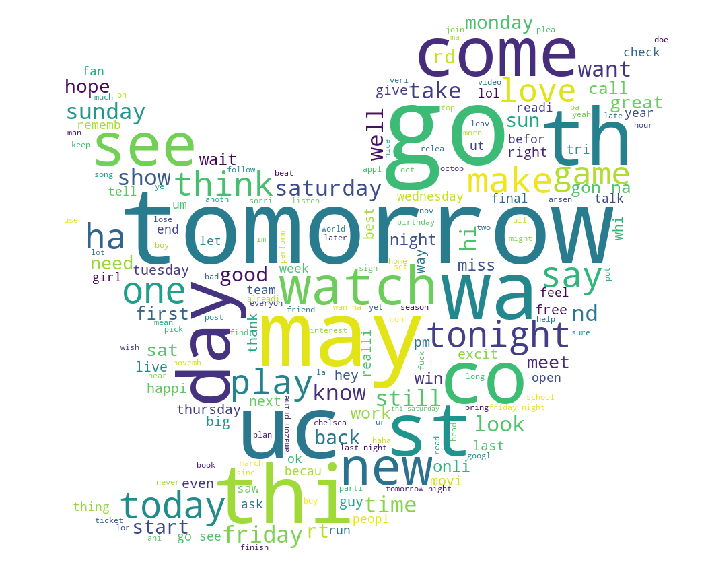

In [6]:
import imageio
from scipy.misc import imread

twitter_mask = imageio.imread('./twitter_mask.png')


wordcloud = WordCloud(
                      background_color='white',
                      width=1800,
                      height=1400,
                      mask=twitter_mask).generate(clean_tweets.to_string())
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig('./t.png', dpi=300)
plt.show()

In [7]:
clean_tweets_test = df_test.text.apply(clean_text)

lexica function gets input the tweets an returns an array of arrays each one with specific metadata values

In [8]:
import random

def lexica(text):
    Location_lex = r'../lexica/generic/generic.txt'
    mydict = {}
    with open(Location_lex) as f: #saved in dictionary
        for line in f:
            if len(line.split()) == 2:
                (key,value) = line.split()
                mydict[key] = value
    metadata = []
    for tweet in text:
        arr = [] #stores the value for every wot foun in the tweet
        tmp = []
        tmp.append(len(tweet.split())) #length of the tweet
        for word in tweet.split():
            if word in mydict:
                arr.append(float(mydict[word]))
        if arr: #if not empty
            tmp.append(min(arr)) #min value
            if min(arr) == max(arr):
                ran = random.randint(-3,3)
                tmp.append(ran)
                tmp.append(((ran+min(arr))/ 2))  
            else:
                tmp.append(max(arr)) #max value
                tmp.append(float(sum(arr) / len(arr)))  #
        else:
            ran1 = random.randint(-3,3)
            ran2 = random.randint(-3,3)
            tmp.append(ran1)
            tmp.append(ran2)
            tmp.append(((ran1+ran2) / 2))  

        metadata.append(tmp)
    return metadata



fit transform for train and test

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
import sys
import numpy

numpy.set_printoptions(threshold=sys.maxsize)
bow_vectorizer = CountVectorizer( max_df=1.0,min_df=1,max_features=300, stop_words='english')

bow_xtrain = bow_vectorizer.fit_transform(clean_tweets)

bow_xtest = bow_vectorizer.fit_transform(clean_tweets_test)

adding our metadata to vector

In [10]:
metadata_train = lexica(df.text)
metadata_test = lexica(df_test.text)
arr_train = []
arr_test = []
for vect in zip(bow_xtrain.toarray(),np.array(metadata_train)): 
    arr_train.append(np.append(vect[0],vect[1]))
for vect in zip(bow_xtest.toarray(),np.array(metadata_test)): 
    arr_test.append(np.append(vect[0],vect[1]))

initializing Classifier

In [11]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)

training the classifier

In [12]:
Y = df.tag
knn.fit(arr_train , Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

prediction

In [13]:
result = knn.predict(arr_test)
from sklearn import metrics
print(metrics.accuracy_score(result, df_corrects.tag))

0.42510582872028657


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer( max_features=300, stop_words='english')

tfidf_train = tfidf_vectorizer.fit_transform(clean_tweets)

tfidf_test = tfidf_vectorizer.fit_transform(clean_tweets_test)

In [19]:
arr_train_tfi = []
arr_test_tfi = []
for vect in zip(tfidf_train.toarray(),np.array(metadata_train)): 
    arr_train_tfi.append(np.append(vect[0],vect[1]))
for vect in zip(tfidf_test.toarray(),np.array(metadata_test)): 
    arr_test_tfi.append(np.append(vect[0],vect[1]))

In [20]:
knn.fit(arr_train_tfi, Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [21]:
result = knn.predict(arr_test_tfi)
print(metrics.accuracy_score(result, df_corrects.tag))

0.42966460436339954


# SVM

In [29]:
from sklearn import svm
clf = svm.SVC(gamma='auto')

In [ ]:
clf.fit(arr_train, Y)
result = clf.predict(arr_test)
print(metrics.accuracy_score(result, df_corrects.tag))

0.45595897101921196


In [ ]:
clf.fit(arr_train_tfi, Y)
result = clf.predict(arr_test_tfi)
print(metrics.accuracy_score(result, df_corrects.tag))